# Functionality: visualization of functional connectivity

## Import Packages 

In [31]:
import os, sys
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

import pickle

from igraph.drawing.text import TextDrawer
import cairo

In [2]:
# import_nbmodule used for import package in .ipynb
import import_nbmodule

# extract the exp folder path
currfolder = os.getcwd()
codefolder = currfolder[0 : currfolder.find('code')+len('code')]

# add path the exp folder
sys.path.append(codefolder)


# import animal_folder function in util/folder_extract.pynb 
from util.folder_extract import exp_subfolders, code_corresfolder

# import graphVisual in connAnalyTool/graphVisual.pynb 
from connAnalyTool import graphVisual

importing Jupyter notebook from /Users/linglingyang/yang7003@umn.edu/NMRC_umn/Projects/FCAnalysis/exp/code/util/folder_extract.ipynb
importing Jupyter notebook from /Users/linglingyang/yang7003@umn.edu/NMRC_umn/Projects/FCAnalysis/exp/code/connAnalyTool/graphVisual.ipynb


## Preparasion

### exp subfolders & code_corresfolder

In [12]:
%%javascript
IPython.notebook.kernel.execute('nb_name = "' + IPython.notebook.notebook_name + '"')

<IPython.core.display.Javascript object>

In [13]:
nb_name = nb_name[0: nb_name.find('.ipynb')]

# corresfolder
corresfolder,correparentfolder = code_corresfolder(os.getcwd(), nb_name)

### global parameters

In [14]:
# frequency
freq = [29, 31]
strfreq = 'freq' + str(freq[0]) + '_' + str(freq[1])


# eventphase
eventphase = 'return'

In [15]:
### text setup for brain areas ###
texts_area = dict()

texts_area['VPLo'] = [20, 40, 20]

texts_area['VLo'] = [20, 120, 20]

texts_area['VA'] = [20, 200, 20]

texts_area['SMA'] = [20, 320, 20]

texts_area['M1'] = [20, 500, 20]

texts_area['STN'] = [280, 140, 20]

texts_area['GP'] = [360, 250, 20]

In [16]:
areas_unwanted = ['lCd','rMC']

In [17]:
WithinM1NoShow = False
STNConnectOnly = False
GPConnectOnly = False
CorticalConnectOnly = False

### input setup

In [18]:
inputfolder = os.path.join(correparentfolder, 'm1_SKT_calcciCOH_' + eventphase 
                           + '_Fre' + str(freq[0]) + '-' + str(freq[1]) +'Hz')
filename = 'ciCOH_STK_' + eventphase  + '_freq_' + str(freq[0]) + '_' + str(freq[1]) + '.pickle'

file = os.path.join(inputfolder, filename)

### save setup

In [19]:
savefolder = corresfolder
savefile_prefix_origin = 'ciCOH_' + eventphase + '_' + strfreq 

## Load ciCOH and Channel

In [20]:
fp = open(file, 'rb')
ciCOH = pickle.load(fp)

In [21]:
# ciCOH
ciCOH_normal, ciCOH_mild = ciCOH['normal'], ciCOH['mild']

# channel information
chnInf_recchni, chnInf_matchni = ciCOH['chnInf_recchni'], ciCOH['chnInf_matchni']
chnInf_brainarea, chnInf_coord = ciCOH['chnInf_brainarea'], ciCOH['chnInf_coord']

## Del unwanted channels

In [22]:
def unwanted_chandata_del(ciCOH, areas_unwanted, chnInf_recchni, chnInf_brainarea, chnInf_coord):
    
    chns_unwanted = []
    for area_unwanted in areas_unwanted:
        for i, area in enumerate(chnInf_brainarea):
            if area == area_unwanted:
                chns_unwanted.append(i)
    
    nchns = ciCOH.shape[0]
    ciCOH = np.delete(ciCOH, chns_unwanted, axis = 0)
    ciCOH = np.delete(ciCOH, chns_unwanted, axis = 1)
    
    
    chnInf_recchni = [i for j, i in enumerate(chnInf_recchni) if j not in chns_unwanted]
    chnInf_brainarea = [i for j, i in enumerate(chnInf_brainarea) if j not in chns_unwanted]
    chnInf_coord = [i for j, i in enumerate(chnInf_coord) if j not in chns_unwanted]

    return ciCOH, chnInf_recchni, chnInf_brainarea, chnInf_coord

In [23]:
ciCOH_normal, chnInf_recchni, chnInf_brainarea, chnInf_coord = \
        unwanted_chandata_del(ciCOH_normal, areas_unwanted, chnInf_recchni, chnInf_brainarea, chnInf_coord)
ciCOH_mild, chnInf_recchni, chnInf_brainarea, chnInf_coord = \
        unwanted_chandata_del(ciCOH_mild, areas_unwanted, chnInf_recchni, chnInf_brainarea, chnInf_coord)

In [24]:
ciCOH_normal_origin, ciCOH_mild_origin = ciCOH_normal, ciCOH_mild

## Show Selection 

## ciCOH Visual

In [25]:
def ciCOH_visual_save(ciCOH, chn_area, chn_coord, str_recchnishow, lowweight, tobesavedfile, texts, 
                      edgeWider = False, edgeWiderMul = 2):
    """
        
        Args:
            
            ciCOH (np.sdarray): ciCOH matrix (nchns, nchns)
            
            chn_area (list): a list of string representing brain area for each channel, len(chn_area) = nchns
            
            chn_coord (numpy.ndarray): x, y coordinates for each channel, shape = (nchns, 2)
            
            chn_recchni(list): showed recording chni for each channel, shape = (nchns, )
            
            lowweight: the threshold lowweight, only weight>lowweight is treated as connection
            
            tobesavedfile: file to save the visualized figure
            
            texts:
            
            edgeWider:
            
            edgeWiderMul: if edgeWider = True, this value is used for wider the edge width
            
        Output:
            the visualizaton of ciCOH is saved in tobesavedfile
            
    """
    
    weight = abs(ciCOH)

    # weight > lowweight
    weight[np.where(weight<lowweight)] =0
    
    graph = graphVisual.graph_create(weight, vsarea = chn_area, vscoord = chn_coord, vschni = str_recchnishow)

    # set graph visualization style
    visual_style = dict()
    if edgeWider:
        visual_style['edge_width'] = [w * edgeWiderMul for w in graph.es['weight']]
    
    visual_style = graphVisual.graph_style(graph, visual_style)
    

    igplot = graphVisual.graph_plot(graph, visual_style, texts = texts)
    
    igplot.save(tobesavedfile)
    
    return igplot

## Save

In [26]:
# threshold lowweight
lowweight = 0.05

edgeWider = True
edgeWiderMul = 1

In [27]:
savefile_prefix = savefile_prefix_origin

if STNConnectOnly:
    ciCOH_normal, ciCOH_mild = ciCOH_normal_onlySTN, ciCOH_mild_onlySTN
    savefile_prefix = savefile_prefix_origin + '_onlySTN'

if GPConnectOnly:
    ciCOH_normal, ciCOH_mild = ciCOH_normal_onlyGP, ciCOH_mild_onlyGP
    savefile_prefix = savefile_prefix_origin + '_onlyGP'
    
if CorticalConnectOnly:
    ciCOH_normal, ciCOH_mild = ciCOH_normal_onlyCortical, ciCOH_mild_onlyCortical
    savefile_prefix = savefile_prefix_origin + '_onlyCortical'

### normal

In [28]:
"""
    normal condition
"""


# save file config
savefilename = savefile_prefix+ '_lowweight' + str(lowweight) + '_normal' + '.png'
savefile = os.path.join(savefolder, savefilename)

# printed text config
texts = texts_area.copy()


# visualize and save
igplot = ciCOH_visual_save(ciCOH_normal, 
                           chn_area = chnInf_brainarea, 
                           chn_coord = chnInf_coord,
                           str_recchnishow = chnInf_recchni,
                           lowweight = lowweight,  
                           tobesavedfile = savefile, 
                           texts = texts,
                           edgeWider = edgeWider, edgeWiderMul = edgeWiderMul)

igplot.show()

print("Figure saved to " + savefile)


# del 
del savefilename, savefile, texts

Figure saved to /Users/linglingyang/yang7003@umn.edu/NMRC_umn/Projects/FCAnalysis/exp/pipeline/NHP_Pinky/1_dataAnaly/FCAnaly/SKT/m2_SKT_visualFC_return_Fre29-31Hz/ciCOH_return_freq29_31_lowweight0.05_normal.png


### mild

In [29]:
"""
    mild condition
"""

condition = 'mild'


# save file config
savefilename = savefile_prefix + '_lowweight' + str(lowweight) + '_' + condition + '.png'
savefile = os.path.join(savefolder, savefilename)

# printed text config
texts = texts_area.copy()

# visualize and save
igplot = ciCOH_visual_save(ciCOH_mild, 
                           chn_area = chnInf_brainarea, 
                           chn_coord = chnInf_coord,
                           str_recchnishow = chnInf_recchni,
                           lowweight = lowweight,  
                           tobesavedfile = savefile, 
                           texts = texts,
                           edgeWider = edgeWider, edgeWiderMul = edgeWiderMul)

igplot.show()

print("Figure saved to " + savefile)

# del 
del savefilename, savefile, texts

Figure saved to /Users/linglingyang/yang7003@umn.edu/NMRC_umn/Projects/FCAnalysis/exp/pipeline/NHP_Pinky/1_dataAnaly/FCAnaly/SKT/m2_SKT_visualFC_return_Fre29-31Hz/ciCOH_return_freq29_31_lowweight0.05_mild.png


### Hist

(-0.14618245296321383, 0.14002739577539278)

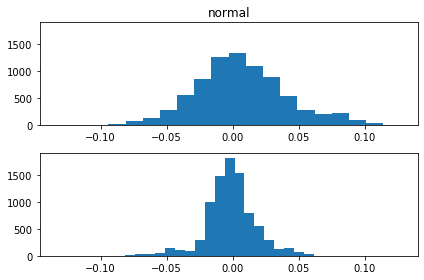

In [35]:
x_mild = np.reshape(ciCOH_mild, (-1))
x_normal = np.reshape(ciCOH_normal, (-1))

n_bins = 20

fig, axs = plt.subplots(2, 1, sharey=True, tight_layout=True)

# We can set the number of bins with the `bins` kwarg
axs[0].hist(x_normal, bins=n_bins, label = 'normal')
axs[0].set_title('normal')
left, right = axs[0].set_xlim()


axs[1].hist(x_mild, bins=n_bins, label = 'mild')

axs[1].set_xlim(left = left, right=right)

(0, 100)

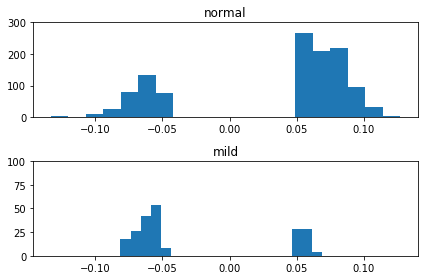

In [48]:
x_mild = np.reshape(ciCOH_mild, (-1))
x_normal = np.reshape(ciCOH_normal, (-1))

x_normal = x_normal[abs(x_normal)>=0.05]
x_mild = x_mild[abs(x_mild)>=0.05]

n_bins = 20

fig, axs = plt.subplots(2, 1, tight_layout=True)

# We can set the number of bins with the `bins` kwarg
axs[0].hist(x_normal, bins=n_bins, label = 'normal')
axs[1].hist(x_mild, bins=n_bins, label = 'mild')

axs[0].set_title('normal')
axs[0].set_ylim(bottom=0, top=300)
left, right = axs[0].set_xlim()
axs[1].set_title('mild')
axs[1].set_xlim(left = left, right=right)

axs[1].set_ylim(bottom=0, top=100)